In [ ]:
# ! cp drive/My\ Drive/CT.zip .
# ! unzip CT.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import nibabel as nib
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import os
import copy 

ngpu = torch.cuda.device_count()
device = torch.device('cpu')# if torch.cuda.is_available() else 'cpu')
print(device, ngpu)

cpu 1


In [2]:
class Mean_Prior_Spine(Dataset):
    def __init__(self, root, imgdir, labeldir, labeldir_left, labeldir_right, device):
        self.root = root
        self.imgdir = imgdir
        self.labeldir = labeldir
        self.labeldir_left = labeldir_left
        self.labeldir_right = labeldir_right
        self.img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        self.seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]
        self.seg_left = [f for f in sorted(os.listdir(root+labeldir_left)) if f.endswith('.npy')]
        self.seg_right = [f for f in sorted(os.listdir(root+labeldir_right)) if f.endswith('.npy')]
        
        prior = np.load('../mean_priors_spine/meanSP.npy')
        self.prior = torch.from_numpy(prior).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_left = copy.deepcopy(prior)
        prior_right = copy.deepcopy(prior)
        prior_full = copy.deepcopy(prior)
        prior_left[prior_left==2] = 0
        prior = torch.from_numpy(prior).unsqueeze(dim=0).type(torch.FloatTensor)
        self.prior_left = torch.from_numpy(prior_left).unsqueeze(dim=0).type(torch.FloatTensor)
        
        prior_right[prior_right==1] = 0
        prior_right[prior_right==2] = 1
        self.prior_right = torch.from_numpy(prior_right).unsqueeze(dim=0).type(torch.FloatTensor)
        
        prior_full[prior_full==2] = 1
        self.prior_full = torch.from_numpy(prior_full).unsqueeze(dim=0).type(torch.FloatTensor)


    def __getitem__(self, index):
        filename_img = os.path.join(self.root, self.imgdir, str(index+1)+'.npy')
        img =  torch.from_numpy(np.load(filename_img)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg = os.path.join(self.root, self.labeldir, str(index+1)+'.npy')
        seg =  torch.from_numpy(np.load(filename_seg)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_left = os.path.join(self.root, self.labeldir_left, str(index+1)+'.npy')
        seg_left =  torch.from_numpy(np.load(filename_seg_left)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_right = os.path.join(self.root, self.labeldir_right, str(index+1)+'.npy')
        seg_right =  torch.from_numpy(np.load(filename_seg_right)).unsqueeze(dim=0).type(torch.FloatTensor)
        seg_full = copy.deepcopy(seg)
        seg_full[seg_full==2]=1
        cat_full = torch.cat((img, self.prior), axis=0)
        cat_left = torch.cat((img, self.prior_left), axis=0)
        cat_right = torch.cat((img, self.prior_right), axis=0)
        cat_hip = copy.deepcopy(cat_full)
        cat_hip[cat_hip==2]=1
        # [ cat_full, cat_left, cat_right, img, seg, seg_left, seg_right] = self.datalist[index]
        
        return {'cat_hip' : cat_hip, 'cat_full' : cat_full, 'cat_left' : cat_left, 'cat_right' : cat_right, \
            'img' : img, 'seg' : seg, 'seg_left' : seg_left, 'seg_right' : seg_right, 'seg_full' : seg_full}

    def __len__(self):
        return len(self.img_fn)


class Prior_Spine(Dataset):
    def __init__(self, root, imgdir, labeldir, labeldir_left, labeldir_right, device):
        self.root = root
        self.imgdir = imgdir
        self.labeldir = labeldir
        self.labeldir_left = labeldir_left
        self.labeldir_right = labeldir_right
        self.img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        self.seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]
        self.seg_left = [f for f in sorted(os.listdir(root+labeldir_left)) if f.endswith('.npy')]
        self.seg_right = [f for f in sorted(os.listdir(root+labeldir_right)) if f.endswith('.npy')]
        
        self.prior_dir = '/home/rahul/MIG/M.Tech/Code/Segmentation_DA_MSD/data/SpineCT_processed/train/prior/'
        self.prior_fn = [f for f in sorted(os.listdir(self.prior_dir+'complete/')) if f.endswith('.npy')]

    def __getitem__(self, index):
        prior_left_fn = os.path.join(self.prior_dir, 'left', self.prior_fn[index])
        prior_left = torch.from_numpy(np.load(prior_left_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_right_fn = os.path.join(self.prior_dir, 'right', self.prior_fn[index])
        prior_right = torch.from_numpy(np.load(prior_right_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_full_fn = os.path.join(self.prior_dir, 'full', self.prior_fn[index])
        prior_full = torch.from_numpy(np.load(prior_full_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_comp_fn = os.path.join(self.prior_dir, 'complete', self.prior_fn[index])
        prior_comp = torch.from_numpy(np.load(prior_comp_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_img = os.path.join(self.root, self.imgdir, self.prior_fn[index])
        img =  torch.from_numpy(np.load(filename_img)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg = os.path.join(self.root, self.labeldir,self.prior_fn[index])
        seg =  torch.from_numpy(np.load(filename_seg)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_left = os.path.join(self.root, self.labeldir_left, self.prior_fn[index])
        seg_left =  torch.from_numpy(np.load(filename_seg_left)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_right = os.path.join(self.root, self.labeldir_right, self.prior_fn[index])
        seg_right =  torch.from_numpy(np.load(filename_seg_right)).unsqueeze(dim=0).type(torch.FloatTensor)
        seg_full = copy.deepcopy(seg)
        seg_full[seg_full==2]=1
        
        cat_full = torch.cat((img, prior_full), axis=0)
        cat_left = torch.cat((img, prior_left), axis=0)
        cat_right = torch.cat((img, prior_right), axis=0)
        cat_hip = torch.cat((img, prior_comp), axis=0)
        # cat_hip[cat_hip==2]=1
        # [ cat_full, cat_left, cat_right, img, seg, seg_left, seg_right] = self.datalist[index]
        
        return {'cat_hip' : cat_hip, 'cat_full' : cat_full, 'cat_left' : cat_left, 'cat_right' : cat_right, \
            'img' : img, 'seg' : seg, 'seg_left' : seg_left, 'seg_right' : seg_right, 'seg_full' : seg_full}

    def __len__(self):
        return len(self.prior_fn)

In [3]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv):
        super(MyConvTranspose2d, self).__init__()
#         self.output_size = output_size
        self.conv = conv
        
    def forward(self, x, output_size):
        x = self.conv(x, output_size=output_size)
        return x
    
class conv_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_filters, (3, 3), padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_filters) 
    
    def forward(self, inp_tensor):
        encoder = self.conv1(inp_tensor)
        encoder = self.conv1_bn(encoder)
        encoder = torch.relu(encoder)
        encoder = self.conv2(encoder)
        encoder = self.conv2_bn(encoder)
        encoder = torch.relu(encoder)
        return encoder

class encoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(encoder_block, self).__init__()
        self.conv_block1 = conv_block(num_channels, num_filters)
        self.max_pool1 = nn.MaxPool2d((2, 2), (2, 2))
    
    def forward(self, inp_tensor):
        encoder = self.conv_block1(inp_tensor)
        encoder_pool = self.max_pool1(encoder)
        return (encoder_pool, encoder)

class decoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(decoder_block, self).__init__()
        conv = nn.ConvTranspose2d(num_channels, num_filters, (2, 2), stride=(2, 2))
        self.conv_tp1 = MyConvTranspose2d(conv)
        self.conv_tp1_bn = nn.BatchNorm2d(2*num_filters)
        self.conv_tp2 = nn.Conv2d(2*num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp2_bn = nn.BatchNorm2d(num_filters)
        self.conv_tp3 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp3_bn = nn.BatchNorm2d(num_filters)

    def forward(self, inp_tensor, concat_tensor, output_size):
        decoder = self.conv_tp1(inp_tensor,output_size=output_size)
        decoder = torch.cat((concat_tensor, decoder), 1)
        decoder = self.conv_tp1_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp2(decoder)
        decoder = self.conv_tp2_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp3(decoder)
        decoder = self.conv_tp3_bn(decoder)
        decoder = torch.relu(decoder)
        return decoder

In [4]:
class UNet2D(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super(UNet2D, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
#         self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
#         self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
    
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
#         encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8

        center = self.center(encoder3_pool) # center (8)

#         decoder4 = self.decoder_block4(center, encoder4) # 16
        
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [5]:
root_dir = '../data/SpineCT_processed/train/'
imgdir = 'imagesTr'
labeldir = 'labelsTr'
labeldir_left = 'labels_left'
labeldir_right = 'labels_right'

validation_split = 0.2
shuffle_dataset = True
random_seed= 42
batch_size = 4
train_ratio = 1

dataset = Prior_Spine(root = root_dir, imgdir = imgdir, labeldir = labeldir, labeldir_left = labeldir_left, labeldir_right = labeldir_right, device = torch.device('cpu'))

np.random.seed(0)
torch.manual_seed(0)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [6]:
np.random.seed(0)
torch.manual_seed(0)

train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
n_train = len(train_loader)
n_val = len(validation_loader)
a = iter(train_loader)
batch = a.next()
print(len(batch), n_train, n_val)

9 1641 410


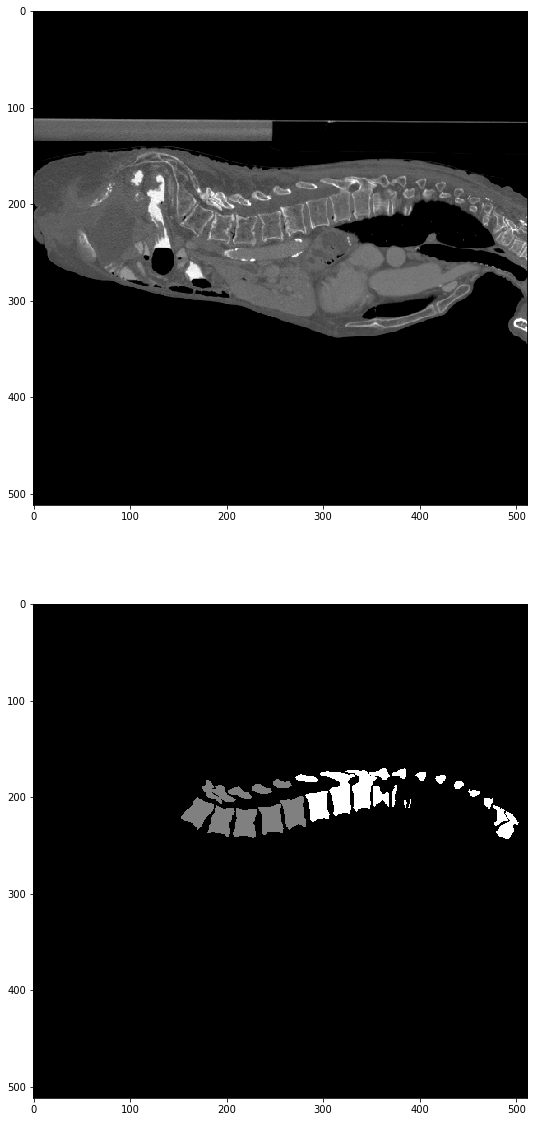

In [7]:
# print(np.unique(dataset[10][2]))
fig = plt.figure(figsize=(10,20))
plt.subplot(2,1,1).imshow(dataset[6500]['img'].squeeze().numpy(), cmap='gray')
plt.subplot(2,1,2).imshow(dataset[6500]['seg'].squeeze().numpy(), cmap='gray')
plt.show()

In [8]:
class MO_Net_encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(MO_Net_encoder, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
        # self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
        
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
        # encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8
        center = self.center(encoder3_pool) # center (8)

        return encoder0, encoder1, encoder2, encoder3, center


class MO_Net_decoder(nn.Module):
    def __init__(self, num_classes):
        super(MO_Net_decoder, self).__init__()
        # self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
            
    def forward(self, encoder0, encoder1, encoder2, encoder3, center):
        # center = x # (8)

        # decoder4 = self.decoder_block4(center, encoder3) # 16
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    # print(y_true.shape, y_pred.shape)
    assert y_true.shape == y_pred.shape, "Tensor dimensions must match"
    shape = y_true.shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = torch.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (torch.sum(y_true_flat) + torch.sum(y_pred_flat) + smooth)
    return score

def dice_coeff_multiclass(y_true, y_pred, num_classes):
    dice = []
    output = torch.argmax(y_pred, dim=1).unsqueeze(dim=1)
    # print(output.shape)
    # y_true = y_true.squeeze(0)
    # print(torch.unique(y_true), torch.unique(output))
    # print(output.shape, y_true.shape)
    for i in range(num_classes):
        segs = y_true.clone().detach()
        segs[y_true==i]=1
        segs[y_true!=i]=0
        # print(torch.unique(segs==y_true))
        outs = output.clone().detach()
        outs[output==i]=1
        outs[output!=i]=0
        # print(torch.unique(outs==output))
        dice.append(dice_coeff(segs, outs).item())
    # print(dice)
    return dice, output, y_true

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model..unsqueeze(0)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def bce_dice_loss(y_true, y_pred):
    loss = F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)
    return loss

def cross_ent_dice_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    loss = nn.CrossEntropyLoss
    # y_pred = torch.argmax(y_pred, 1)
    loss = F.cross_entropy(y_pred.float(), y_true) + dice_loss(y_true, y_pred)
    return loss

In [10]:
def plot_images(title, scan, seg, unet, mounet, nftnet, subnet):
    fig = plt.figure(figsize=(20,5))
    fig.suptitle(title, fontsize=20)
    plt.subplot(1,6,1).imshow(scan, cmap='gray')
    plt.subplot(1,6,1).set_title('Scan', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,2).imshow(seg, cmap='gray')
    plt.subplot(1,6,2).set_title('Segmentation GT', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,3).imshow(unet, cmap='gray')
    plt.subplot(1,6,3).set_title('U-Net', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,4).imshow(mounet, cmap='gray')
    plt.subplot(1,6,4).set_title('MOU-Net', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,5).imshow(nftnet, cmap='gray')
    plt.subplot(1,6,5).set_title('NFTNet', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,6,6).imshow(subnet, cmap='gray')
    plt.subplot(1,6,6).set_title('SUBNet', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [11]:
input_img = Variable(dataset[6500]['img']).unsqueeze(0).to(device)
input_img_prior = Variable(dataset[6500]['cat_full']).unsqueeze(0).to(device)
seg_inp = Variable(dataset[6500]['seg'].type(torch.LongTensor)).unsqueeze(0).to(device)
# print(input_img.shape)
# input_img = input_img.repeat(4,1,1,1)
# seg_inp = seg_inp.repeat(4,1,1,1)
# print(input_img.shape)

ipykernel_launcher:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured

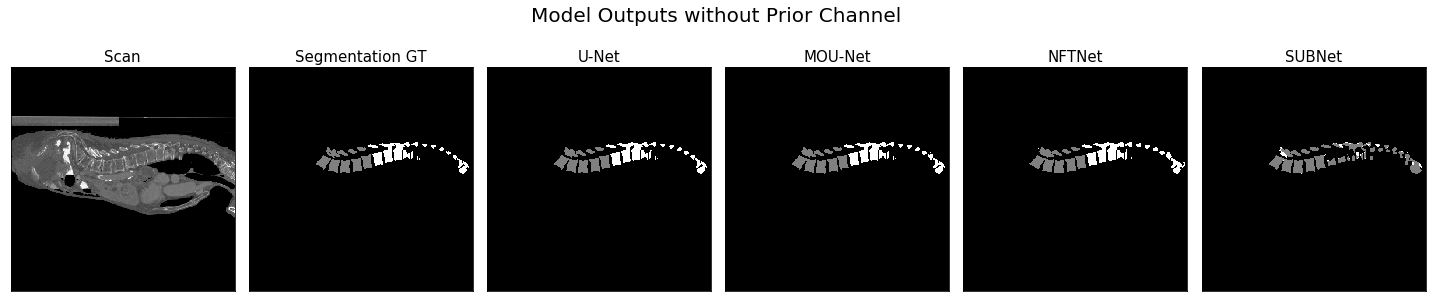

In [173]:
title = 'Model Outputs without Prior Channel'
plot_images(title, input_img[0][0], seg_inp[0][0], outs_uwout_prior.squeeze(), outs_nftwout_prior.squeeze(), outs_mouwout_prior.squeeze(), outs_subwout_prior.squeeze())
# title = 'Model Outputs with Prior Channel'
# plot_images(title, input_img[0][0], seg_inp[0][0], outs_uw_prior.squeeze(), outs_nftw_prior.squeeze(), outs_mouw_prior.squeeze(), outs_subw_prior.squeeze())
# outs_uw_prior, outs_nftw_prior, outs_mouw_prior, outs_subw_prior

In [154]:
model = UNet2D(3, 1).to(device)
model.load_state_dict(torch.load('../Spine_noSP/UNet/UNet_30_4_0.0002_1_1_3_epoch_30.pt'))

<All keys matched successfully>

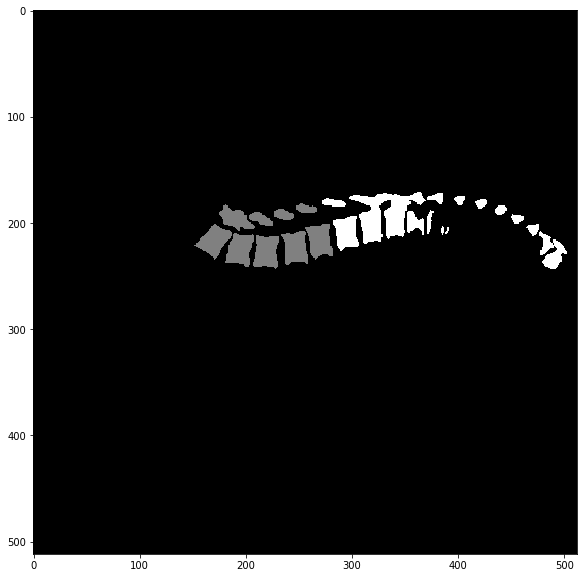

In [155]:
outputs = model(input_img)
dscoeff, outs_uwout_prior, segs = dice_coeff_multiclass(seg_inp, outputs, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_uwout_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [156]:
model = UNet2D(3, 2).to(device)
model.load_state_dict(torch.load('../Spine_priorSP/UNet/UNet_30_4_0.0002_1_2_3_epoch_30.pt'))

<All keys matched successfully>

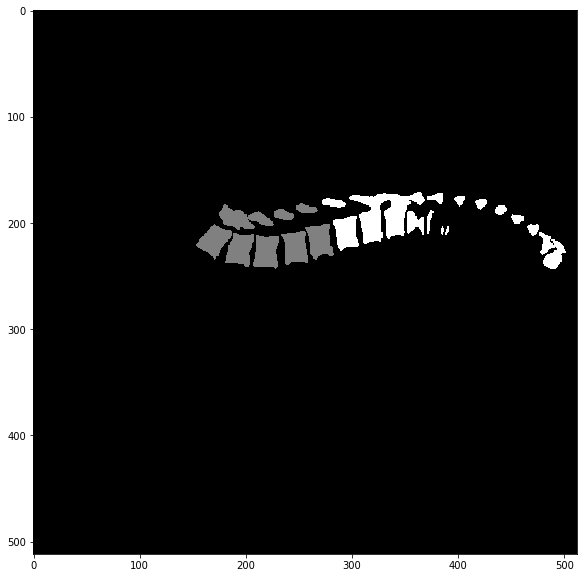

In [157]:
outputs = model(input_img_prior )
dscoeff, outs_uw_prior, segs = dice_coeff_multiclass(seg_inp, outputs, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_uw_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [158]:
model = UNet2D(3, 1).to(device)
model.load_state_dict(torch.load('../Spine_noSP/NFTNet/NFTNet_15_15_4_0.0002_1_1_3_epoch_15.pt'))

<All keys matched successfully>

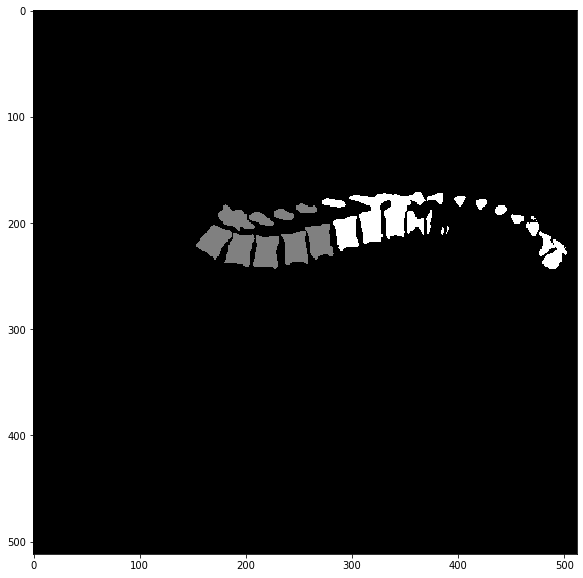

In [159]:
outputs = model(input_img)
dscoeff, outs_nftwout_prior, segs = dice_coeff_multiclass(seg_inp, outputs, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_nftwout_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [160]:
model = UNet2D(3, 2).to(device)
model.load_state_dict(torch.load('../Spine_priorSP/NFTNet/NFTNet_15_15_4_0.0002_1_2_3_epoch_15.pt'))

<All keys matched successfully>

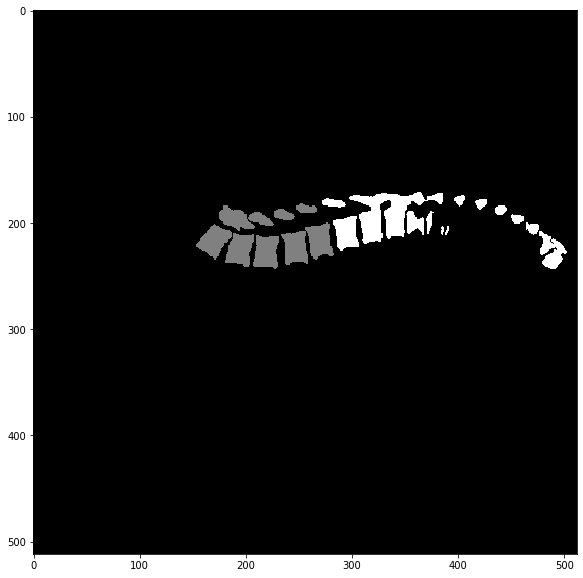

In [161]:
outputs = model(input_img_prior )
dscoeff, outs_nftw_prior, segs = dice_coeff_multiclass(seg_inp, outputs, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_nftw_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [162]:
model_enc = MO_Net_encoder(1).to(device)
model_dec = MO_Net_decoder(3).to(device)
model_enc.load_state_dict(torch.load('../Spine_noSP/MOUNet/enc_MOUNet_15_15_4_0.0002_1_1_3_epoch_15.pt'))
model_dec.load_state_dict(torch.load('../Spine_noSP/MOUNet/dec_MOUNet_15_15_4_0.0002_1_1_3_epoch_15.pt'))

<All keys matched successfully>

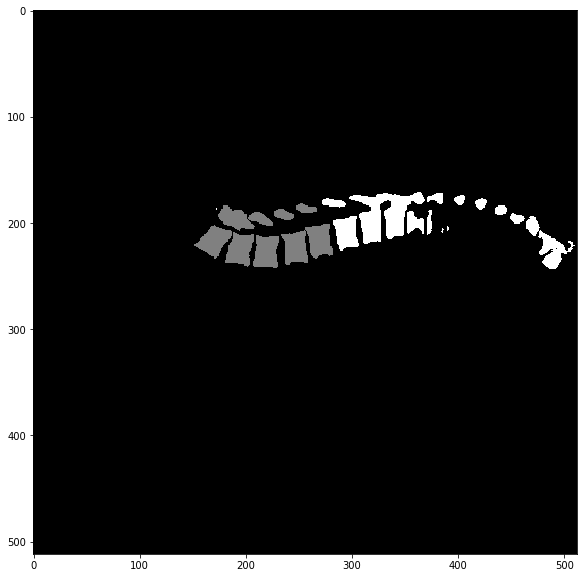

In [163]:
encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img)
outputs2 = model_dec(encoder0, encoder1, encoder2, encoder3, center)
dscoeff, outs_mouwout_prior, segs = dice_coeff_multiclass(seg_inp, outputs2, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_mouwout_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [164]:
model_enc = MO_Net_encoder(2).to(device)
model_dec = MO_Net_decoder(3).to(device)
model_enc.load_state_dict(torch.load('../Spine_priorSP/MOUNet/enc_MOUNet_15_15_4_0.0002_1_2_3_epoch_15.pt'))
model_dec.load_state_dict(torch.load('../Spine_priorSP/MOUNet/dec_MOUNet_15_15_4_0.0002_1_2_3_epoch_15.pt'))

<All keys matched successfully>

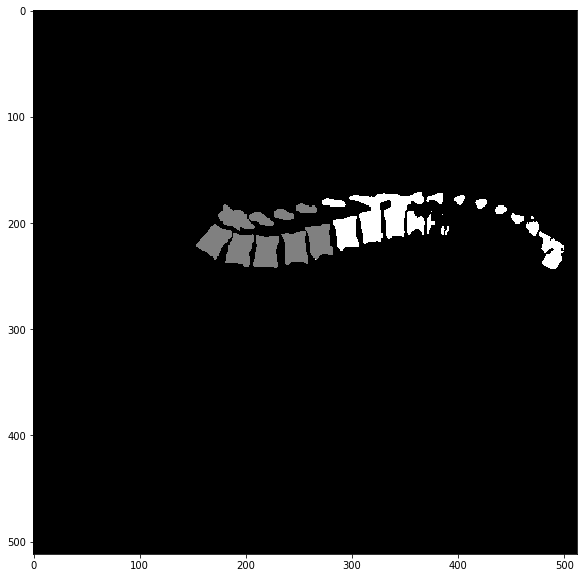

In [165]:
encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img_prior)
outputs2 = model_dec(encoder0, encoder1, encoder2, encoder3, center)
dscoeff, outs_mouw_prior, segs = dice_coeff_multiclass(seg_inp, outputs2, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs_mouw_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [166]:
model_left = UNet2D(2,1).to(device)
model_full = UNet2D(2,1).to(device)
model_full.load_state_dict(torch.load('../Spine_noSP/SUBNet/SUBNet_15_15_4_0.0002_1_1_3_full__epoch_15.pt'))
model_left.load_state_dict(torch.load('../Spine_noSP/SUBNet/SUBNet_15_15_4_0.0002_1_1_3_left__epoch_15.pt'))


<All keys matched successfully>

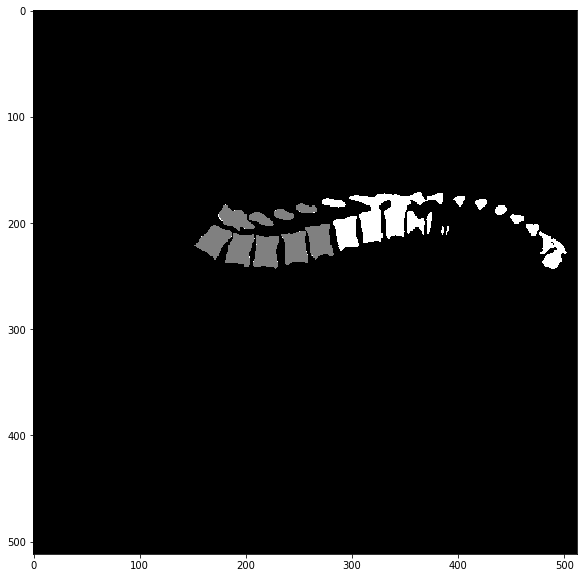

In [167]:
outputs1 = model_full(input_img)
dscoeff, out1, segs = dice_coeff_multiclass(seg_inp, outputs1, 2)
outputs2 = model_left(input_img)
dscoeff, out2, segs = dice_coeff_multiclass(seg_inp, outputs2, 2)
out3 = out1-out2
out3[out3<0]=0
out3[out3!=0]=2
out3 += out2
out3[out3>2]=2
outs_subw_prior = out3
plt.figure(figsize=(10,10))
plt.imshow(outs_subw_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [168]:
model_left = UNet2D(2,2).to(device)
model_full = UNet2D(2,2).to(device)
model_full.load_state_dict(torch.load('../Spine_priorSP/SUBNet/SUBNet_15_15_4_0.0002_1_2_3_full__epoch_15.pt'))
model_left.load_state_dict(torch.load('../Spine_priorSP/SUBNet/SUBNet_15_15_4_0.0002_1_2_3_left__epoch_15.pt'))

<All keys matched successfully>

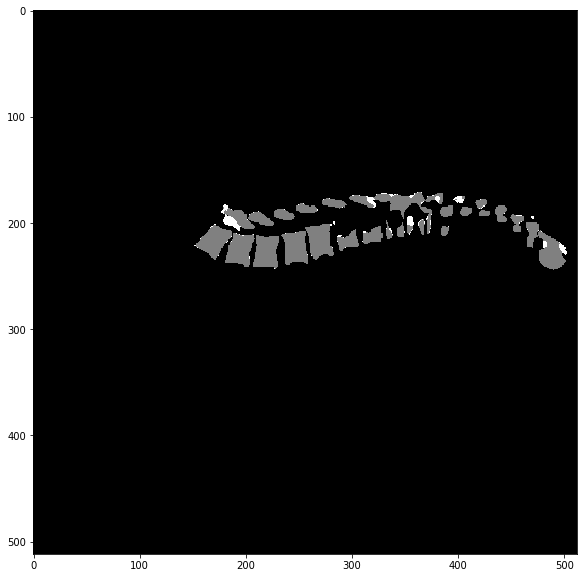

In [169]:
outputs1 = model_full(input_img_prior)
dscoeff, out1, segs = dice_coeff_multiclass(seg_inp, outputs1, 2)
outputs2 = model_left(input_img_prior)
dscoeff, out2, segs = dice_coeff_multiclass(seg_inp, outputs2, 2)
out3 = out1-out2
out3[out3<0]=0
out3[out3!=0]=2
out3 += out2
out3[out3>2]=2
outs_subwout_prior = out3
plt.figure(figsize=(10,10))
plt.imshow(outs_subwout_prior[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

In [23]:
def plot_priors(seg, full_prior, left_prior, right_prior, left_right_prior):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,5,1).imshow(seg, cmap='gray')
    plt.subplot(1,5,1).set_title('Model Input', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,2).imshow(full_prior, cmap='gray')
    plt.subplot(1,5,2).set_title('Full Spine Prior', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,3).imshow(left_prior, cmap='gray')
    plt.subplot(1,5,3).set_title('LS Prior', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,4).imshow(right_prior, cmap='gray')
    plt.subplot(1,5,4).set_title('NLS Prior', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,5).imshow(left_right_prior, cmap='gray')
    plt.subplot(1,5,5).set_title('Complete Spine prior', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [12]:
model = UNet2D(3, 1).to(device)
model.load_state_dict(torch.load('../prior_models/spine_full/UNet/UNet_15_2_0.0002_1_1_3_epoch_15.pt'))

<All keys matched successfully>

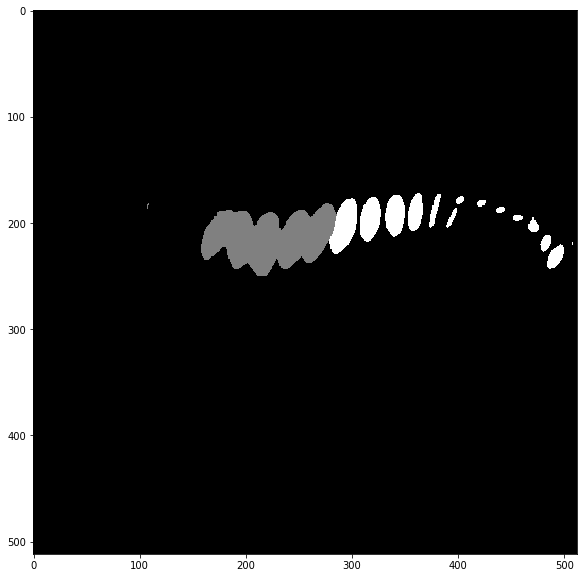

In [14]:
outputs = model(input_img)
dscoeff, outs, segs = dice_coeff_multiclass(seg_inp, outputs, 3)
plt.figure(figsize=(10,10))
plt.imshow(outs[0].squeeze().cpu().numpy(), cmap='gray') 
plt.show()

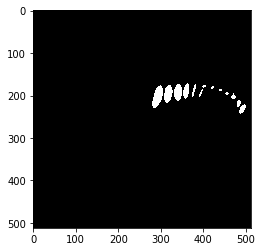

In [17]:
seg_full = copy.deepcopy(outs[0])
seg_left = copy.deepcopy(outs[0])
seg_right = copy.deepcopy(outs[0])
seg_full[seg_full>=1] = 1
seg_left[seg_left==2] = 0
seg_right[seg_right==1] = 0
seg_right[seg_right==2] = 1

plt.imshow(seg_right.squeeze().cpu().numpy(), cmap='gray') 
plt.show()

ipykernel_launcher:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured

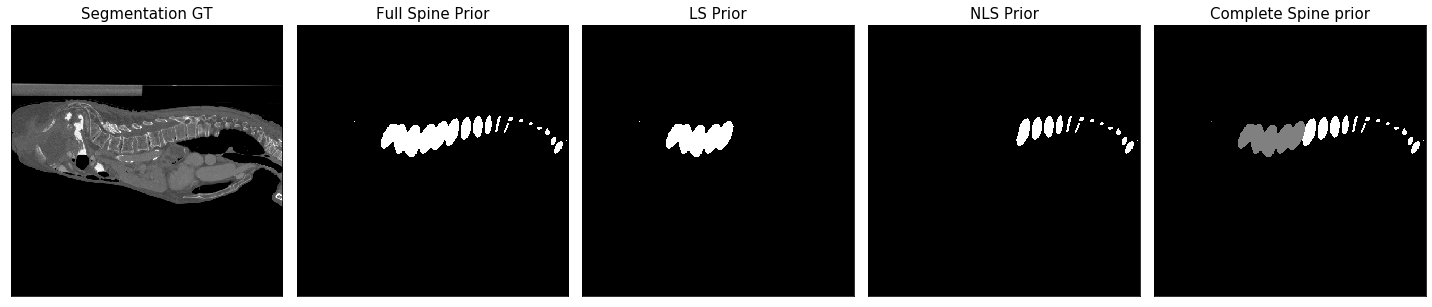

In [25]:
plot_priors(input_img[0].squeeze(), seg_full.squeeze(), seg_left.squeeze(), seg_right.squeeze(), outs[0].squeeze())